# Bayes Opt with 2D Cartesian Space

Here's what we are doing in this notebook

1. Generate synthetic noisy data (GP sampling)
2. Visualize this contour (2D and 3D)
3. Do Bayes Opt sequentially, visualizing:
   1. The inferred GP surface (assuming a known length scale GP) - mean and std
   2. the thompson's samples


In [36]:
# Import Packages

import numpy as np
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display


In [37]:
# Tunable length-scale parameter
LENGTH_SCALE = 0.2
KERNEL_STD = 3.0
NOISE_STD = 0.1
DEBUG = True

In [38]:
def heat_kernel(x, y, length_scale=LENGTH_SCALE, sigma_f=1.0):
    d = np.linalg.norm(x - y)
    return sigma_f**2 * np.exp(-d**2/(2*length_scale**2))

class SyntheticData:
    def __init__(self, grid_x, grid_y, length_scale=LENGTH_SCALE, sigma_f=1.0, noise=0.1):
        self.X = np.array([[x, y] for x in grid_x for y in grid_y])
        n = self.X.shape[0]
        K = np.array([[heat_kernel(self.X[i], self.X[j], length_scale, sigma_f)
                       for j in range(n)] for i in range(n)])
        f = np.random.multivariate_normal(np.zeros(n), K)
        self.Y = f + noise*np.random.randn(n)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_static_ground_truth(X, Y, grid_size):
    X_grid = X[:,0].reshape(grid_size, grid_size)
    Y_grid = X[:,1].reshape(grid_size, grid_size)
    Z_grid = Y.reshape(grid_size, grid_size)

    # Create a 1x2 subplot grid
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Adjust size as needed

    # 2D plot
    cp = axes[0].contourf(X_grid, Y_grid, Z_grid, cmap='viridis')
    axes[0].set_title("Ground Truth 2D")
    fig.colorbar(cp, ax=axes[0])

    # 3D plot
    ax3d = fig.add_subplot(122, projection='3d')  # Set the 3D plot in the second subplot
    ax3d.plot_surface(X_grid, Y_grid, Z_grid, cmap='viridis')
    ax3d.set_title("Ground Truth 3D")

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()


In [39]:
class GPflowGP:
    def __init__(self, X_all, noise=0.1, length_scale=LENGTH_SCALE, sigma_f=1.0):
        self.X_all = X_all.astype(np.float64)
        self.noise = noise
        self.length_scale = length_scale
        self.sigma_f = sigma_f
        self.X_train = None
        self.y_train = None
        self.model = None

    def _build_model(self):
        kernel = gpflow.kernels.SquaredExponential(lengthscales=self.length_scale,
                                                   variance=self.sigma_f**2)
        self.model = gpflow.models.GPR(data=(self.X_train, self.y_train), kernel=kernel)
        self.model.likelihood.variance.assign(self.noise**2)
        opt = gpflow.optimizers.Scipy()
        opt.minimize(self.model.training_loss, self.model.trainable_variables,
                     options=dict(maxiter=100))
        if DEBUG:
            print(f"    Learned length scale: {self.model.kernel.lengthscales.numpy()}")

    def update(self, x_new, y_new):
        x_new = np.array(x_new, ndmin=2, dtype=np.float64)
        y_new = np.array(y_new, ndmin=2, dtype=np.float64)
        if self.X_train is None:
            self.X_train = x_new
            self.y_train = y_new
        else:
            self.X_train = np.vstack([self.X_train, x_new])
            self.y_train = np.vstack([self.y_train, y_new])
        self._build_model()

    def predict(self):
        mean, var = self.model.predict_f(self.X_all)
        return mean.numpy().flatten(), np.sqrt(var.numpy().flatten())

    def thompson_sample(self):
        samples = self.model.predict_f_samples(self.X_all, 1)
        return samples.numpy().reshape(-1)

class BayesOptimizer:
    def __init__(self, gp, Y, X):
        self.gp = gp
        self.Y = Y
        self.X = X
        self.history = []       # List of (point, value)
        self.iter_data = []     # Each entry: {iter, mean, std, candidate, thompson, history}
    
    def optimize(self, iterations=10):
        print(f"Ground Truth Max: {np.max(self.Y):.3f} at {self.X[np.argmax(self.Y)]}")
        print("Iter 0:")
        best_val = -np.inf
        best_x = None
        # Start with a random sample.
        idx = np.random.choice(len(self.X))
        self.gp.update(self.X[idx], self.Y[idx])
        self.history.append((self.X[idx], self.Y[idx]))
        mean, std = self.gp.predict()
        # thompson = self.gp.thompson_sample()
        self.iter_data.append({'iter': 0, 'mean': mean.copy(), 'std': std.copy(),
                               'candidate': self.X[idx], 'thompson': np.zeros(mean.shape),
                               'history': list(self.history)})
        print(f"    (Random Sample) Chosen {self.X[idx]} value: {self.Y[idx]:.3f}")
        if self.Y[idx] > best_val: 
            best_val, best_x = self.Y[idx], self.X[idx]
        for it in range(1, iterations+1):
            print(f"Iter {it}:")
            sample = self.gp.thompson_sample()
            idx = np.argmax(sample)
            self.gp.update(self.X[idx], self.Y[idx])
            self.history.append((self.X[idx], self.Y[idx]))
            if self.Y[idx] > best_val: 
                best_val, best_x = self.Y[idx], self.X[idx]
            mean, std = self.gp.predict()
            # thompson = self.gp.thompson_sample()
            self.iter_data.append({'iter': it, 'mean': mean.copy(), 'std': std.copy(),
                                   'candidate': self.X[idx], 'thompson': sample.copy(),
                                   'history': list(self.history)})
            print(f"    Chosen {self.X[idx]} value: {self.Y[idx]:.3f}")
        return best_x, best_val


def interactive_plot(iter_data, grid_size, Y_true, gt_coord):
    x_lin = np.linspace(0, 1, grid_size)
    # Use ground truth range for predicted mean and ground truth panels.
    vmin = np.min(Y_true)
    vmax = np.max(Y_true)
    
    def update_plot(it):
        data = iter_data[it]
        mean_field = data['mean'].reshape(grid_size, grid_size)
        std_field = data['std'].reshape(grid_size, grid_size)
        thompson_field = data['thompson'].reshape(grid_size, grid_size)
        history = data['history']
        candidate = data['candidate']
        if DEBUG:
            print(f"candicate location: {candidate}")
        
        fig, axes = plt.subplots(1, 4, figsize=(24, 6))
        
        # Panel 1: Predicted Mean.
        cp0 = axes[0].contourf(x_lin, x_lin, mean_field, cmap='viridis', vmin=vmin, vmax=vmax)
        if len(history) > 1:
            prev_points = np.array([h[0] for h in history[:-1]])
            axes[0].scatter(prev_points[:,1], prev_points[:,0], c='red', marker='o', s=50, label='Previous')
        axes[0].scatter(candidate[1], candidate[0], c='blue', marker='x', s=100, label='New Sample')
        axes[0].scatter(gt_coord[1], gt_coord[0], c='white', edgecolors='black', marker='*', s=150, label='Ground Truth Max')
        axes[0].set_title(f"Predicted Mean (Iter {data['iter']})")
        axes[0].legend()
        fig.colorbar(cp0, ax=axes[0])
        
        # Panel 2: Predicted Std Dev.
        cp1 = axes[1].contourf(x_lin, x_lin, std_field, cmap='viridis')
        axes[1].set_title("Predicted Std Dev")
        fig.colorbar(cp1, ax=axes[1])
        
        # Panel 3: Thompson Sample.
        cp2 = axes[2].contourf(x_lin, x_lin, thompson_field, cmap='viridis')
        # Compute maximum in the thompson sample.
        max_idx = np.argmax(thompson_field)
        i, j = np.unravel_index(max_idx, thompson_field.shape)
        thompson_max_x = x_lin[j]
        thompson_max_y = x_lin[i]

        axes[2].scatter(thompson_max_x, thompson_max_y, c='blue', marker='x', s=100, label='Thompson Max')
        # axes[2].scatter(candidate[0], candidate[1], c='blue', marker='x', s=100, label='New Sample')
        axes[2].set_title("Thompson Sample")
        axes[2].legend()
        fig.colorbar(cp2, ax=axes[2])
        
        # Panel 4: Ground Truth (static).
        Z_true = Y_true.reshape(grid_size, grid_size)
        cp3 = axes[3].contourf(x_lin, x_lin, Z_true, cmap='viridis', vmin=vmin, vmax=vmax)
        axes[3].scatter(gt_coord[1], gt_coord[0], c='white', edgecolors='black', marker='*', s=150, label='Ground Truth Max')
        axes[3].set_title("Ground Truth")
        axes[3].legend()
        fig.colorbar(cp3, ax=axes[3])
        
        plt.show()
    
    slider = widgets.IntSlider(min=0, max=len(iter_data)-1, step=1, value=0, description='Iteration')
    widgets.interact(update_plot, it=slider)


Ground Truth Maximum at [1.         0.24137931] with value 4.804


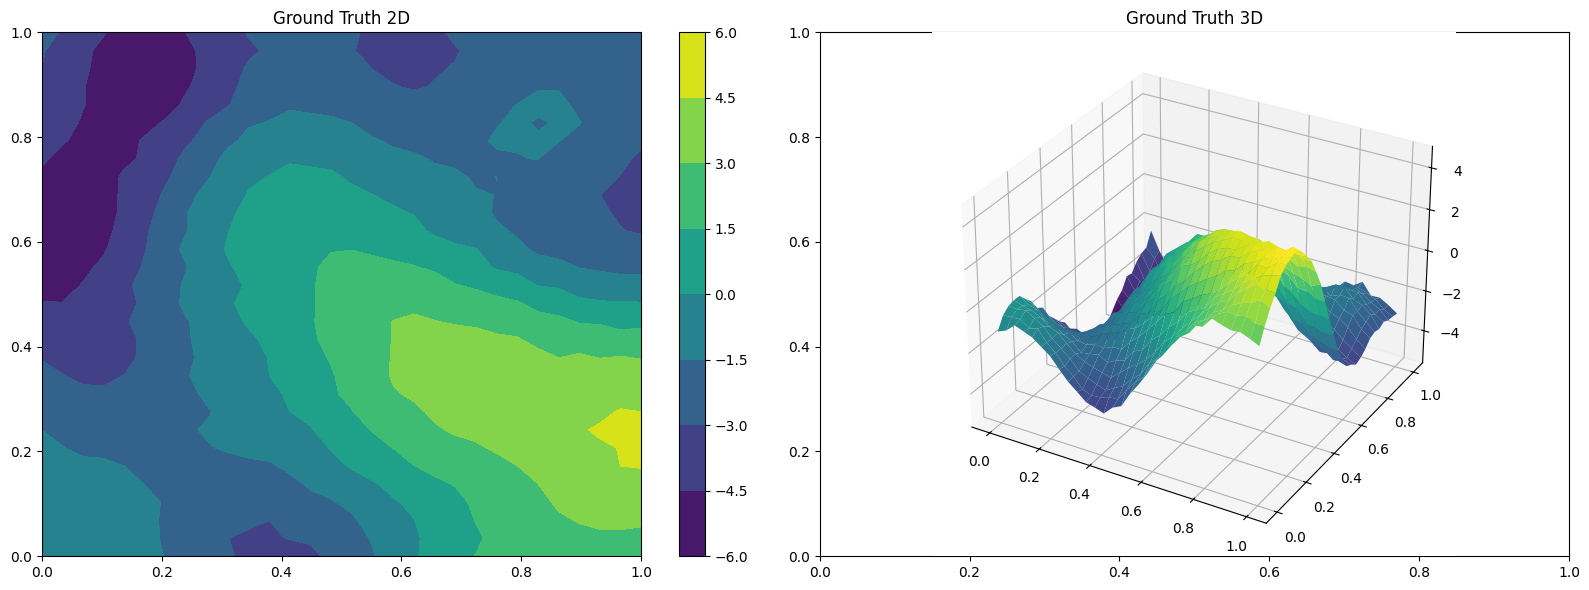

In [40]:
grid_size = 30
grid = np.linspace(0, 1, grid_size)
X = np.array([[x, y] for x in grid for y in grid])
data_obj = SyntheticData(grid, grid, noise=NOISE_STD, sigma_f=KERNEL_STD)
Y = data_obj.Y
gt_coord = X[np.argmax(Y)]
print(f"Ground Truth Maximum at {gt_coord} with value {np.max(Y):.3f}")

# Plot static ground truth.
plot_static_ground_truth(X, Y, grid_size)
  

In [41]:
# Run Bayesian optimization.
gp = GPflowGP(X, noise=0.1)
optimizer = BayesOptimizer(gp, Y, X)
best_x, best_val = optimizer.optimize(iterations=30)
print("Best location:", best_x, "Best value:", best_val)
print("Ground Truth Location:", gt_coord, "Ground Truth Value:", np.max(Y))

# Interactive 4-panel plot.
interactive_plot(optimizer.iter_data, grid_size, Y, gt_coord)


Ground Truth Max: 4.804 at [1.         0.24137931]
Iter 0:
    Learned length scale: 0.2
    (Random Sample) Chosen [0.72413793 0.68965517] value: -1.441
Iter 1:
    Learned length scale: 0.6177826434711035
    Chosen [0.         0.62068966] value: -5.382
Iter 2:
    Learned length scale: 1.606610215773264
    Chosen [0.93103448 1.        ] value: -2.389
Iter 3:
    Learned length scale: 0.8692195692274606
    Chosen [1. 0.] value: 1.916
Iter 4:
    Learned length scale: 0.7213811513294952
    Chosen [1. 0.] value: 1.916
Iter 5:
    Learned length scale: 0.28548747371475686
    Chosen [1.         0.24137931] value: 4.804
Iter 6:
    Learned length scale: 0.2323542079003147
    Chosen [1.         0.34482759] value: 3.641
Iter 7:
    Learned length scale: 0.23153214169580336
    Chosen [0.24137931 0.10344828] value: -1.975
Iter 8:
    Learned length scale: 0.19137223261899322
    Chosen [1.         0.20689655] value: 4.650
Iter 9:
    Learned length scale: 0.19137150800686129
    Chosen 

interactive(children=(IntSlider(value=0, description='Iteration', max=30), Output()), _dom_classes=('widget-in…

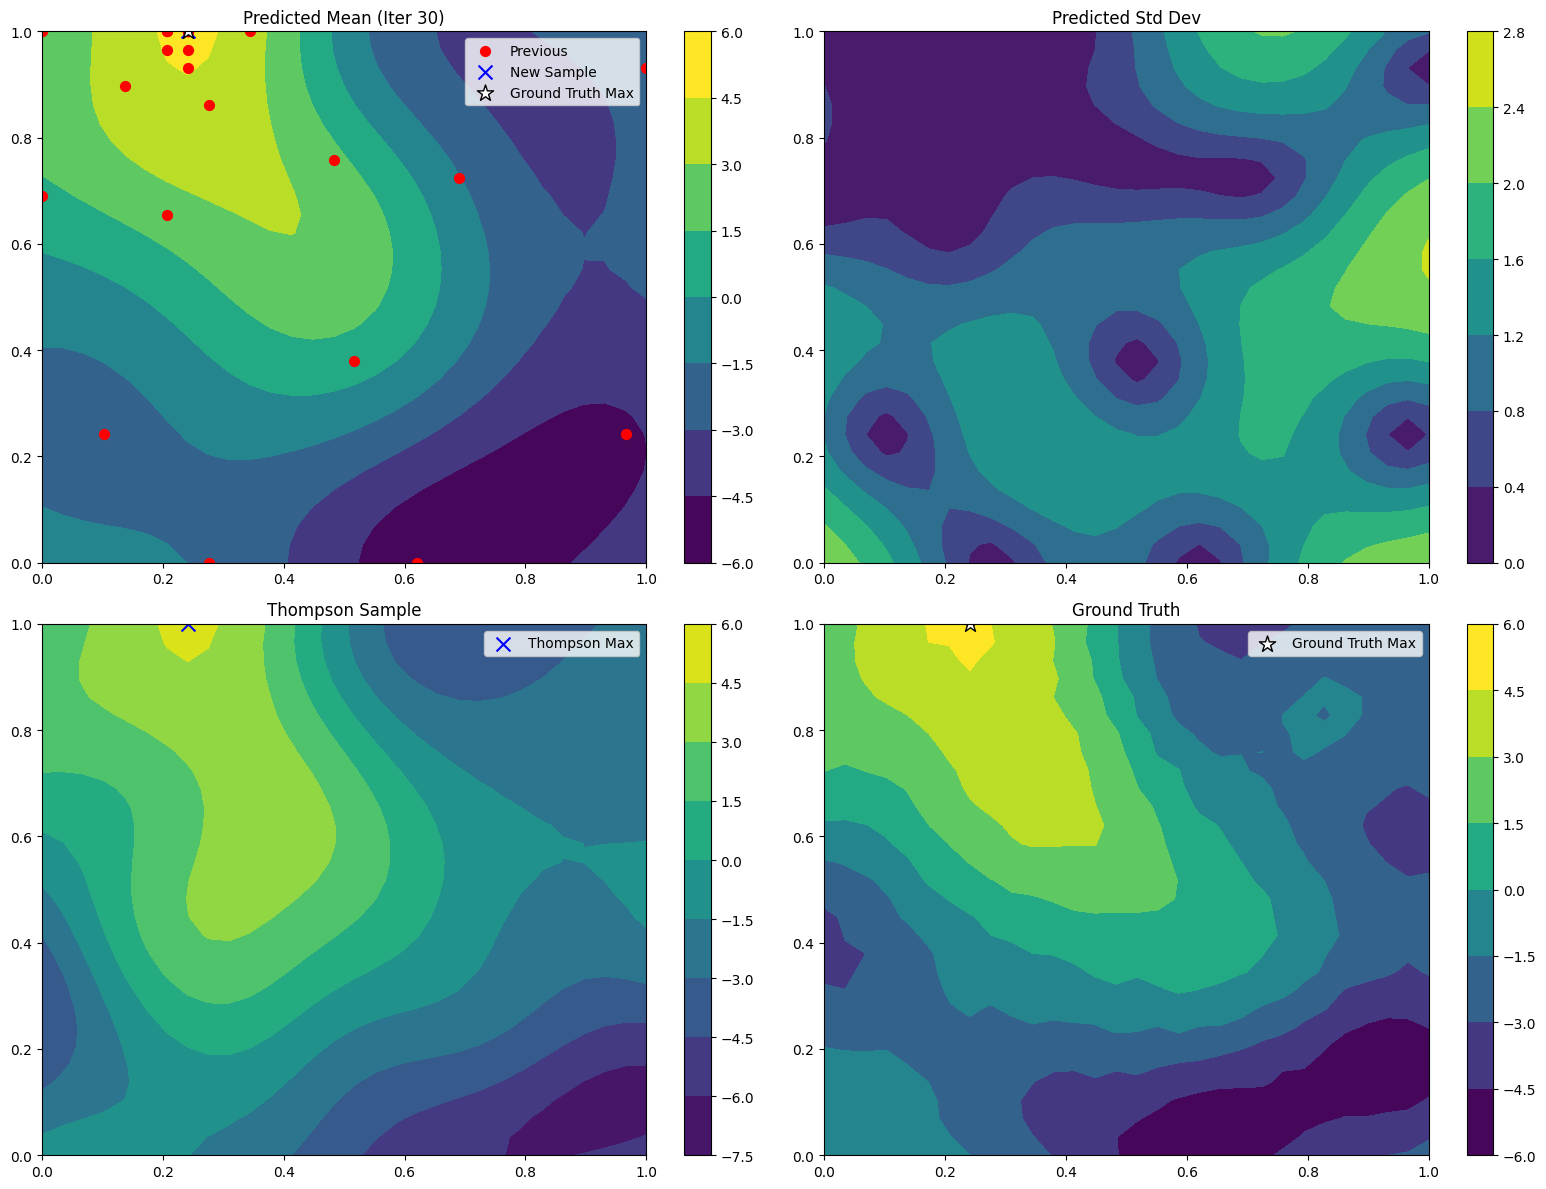

In [42]:
# Static plot for the last iteration
last_iter_data = optimizer.iter_data[-1]
mean_field = last_iter_data['mean'].reshape(grid_size, grid_size)
std_field = last_iter_data['std'].reshape(grid_size, grid_size)
thompson_field = last_iter_data['thompson'].reshape(grid_size, grid_size)
history = last_iter_data['history']
candidate = last_iter_data['candidate']

x_lin = np.linspace(0, 1, grid_size)
vmin = np.min(Y)
vmax = np.max(Y)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Panel 1: Predicted Mean
cp0 = axes[0, 0].contourf(x_lin, x_lin, mean_field, cmap='viridis', vmin=vmin, vmax=vmax)
if len(history) > 1:
    prev_points = np.array([h[0] for h in history[:-1]])
    axes[0, 0].scatter(prev_points[:,1], prev_points[:,0], c='red', marker='o', s=50, label='Previous')
axes[0, 0].scatter(candidate[1], candidate[0], c='blue', marker='x', s=100, label='New Sample')
axes[0, 0].scatter(gt_coord[1], gt_coord[0], c='white', edgecolors='black', marker='*', s=150, label='Ground Truth Max')
axes[0, 0].set_title(f"Predicted Mean (Iter {last_iter_data['iter']})")
axes[0, 0].legend()
fig.colorbar(cp0, ax=axes[0, 0])

# Panel 2: Predicted Std Dev
cp1 = axes[0, 1].contourf(x_lin, x_lin, std_field, cmap='viridis')
axes[0, 1].set_title("Predicted Std Dev")
fig.colorbar(cp1, ax=axes[0, 1])

# Panel 3: Thompson Sample
cp2 = axes[1, 0].contourf(x_lin, x_lin, thompson_field, cmap='viridis')
max_idx = np.argmax(thompson_field)
i, j = np.unravel_index(max_idx, thompson_field.shape)
thompson_max_x = x_lin[j]
thompson_max_y = x_lin[i]
axes[1, 0].scatter(thompson_max_x, thompson_max_y, c='blue', marker='x', s=100, label='Thompson Max')
axes[1, 0].set_title("Thompson Sample")
axes[1, 0].legend()
fig.colorbar(cp2, ax=axes[1, 0])

# Panel 4: Ground Truth (static)
Z_true = Y.reshape(grid_size, grid_size)
cp3 = axes[1, 1].contourf(x_lin, x_lin, Z_true, cmap='viridis', vmin=vmin, vmax=vmax)
axes[1, 1].scatter(gt_coord[1], gt_coord[0], c='white', edgecolors='black', marker='*', s=150, label='Ground Truth Max')
axes[1, 1].set_title("Ground Truth")
axes[1, 1].legend()
fig.colorbar(cp3, ax=axes[1, 1])

plt.tight_layout()
plt.show()